In [18]:
import os
import numpy as np
import cv2
import xml.etree.ElementTree as ET
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping


In [19]:
# === RUTAS ===
cracked_dir = r'C:\Users\marco\AndroidStudioProjects\TFG\TFG-App-IA-IncidenciasViales\ModeloIA\datasets\cracks'
holes_dir = r'C:\Users\marco\AndroidStudioProjects\TFG\TFG-App-IA-IncidenciasViales\ModeloIA\datasets\holes\images'
postesCaidos_dir =r'C:\Users\marco\AndroidStudioProjects\TFG\TFG-App-IA-IncidenciasViales\ModeloIA\datasets\PostesCaidos\train' 
sinIncidencia_dir = r'C:\Users\marco\AndroidStudioProjects\TFG\TFG-App-IA-IncidenciasViales\ModeloIA\datasets\sinIncidencia'


In [20]:
image_paths = []
labels = []

for f in os.listdir(cracked_dir):
    if f.lower().endswith(('.jpg', '.jpeg', '.png')):
        image_paths.append(os.path.join(cracked_dir, f))
        labels.append(0)  # Grieta

for f in os.listdir(holes_dir):
    if f.lower().endswith(('.jpg', '.jpeg', '.png')):
        image_paths.append(os.path.join(holes_dir, f))
        labels.append(1)  

for f in os.listdir(postesCaidos_dir):
    if f.lower().endswith(('.jpg', '.jpeg', '.png')):
        image_paths.append(os.path.join(postesCaidos_dir, f))
        labels.append(2)  

for f in os.listdir(sinIncidencia_dir):
    if f.lower().endswith(('.jpg', '.jpeg', '.png')):
        image_paths.append(os.path.join(sinIncidencia_dir, f))
        labels.append(3)  


print(f"Total imágenes cargadas: {len(image_paths)}")

Total imágenes cargadas: 36424


In [21]:
# Función para cargar y preprocesar imagen
def cargar_y_preprocesar_cv2(file_path):
    img = cv2.imread(file_path)
    if img is None:
        raise ValueError(f"No se pudo cargar la imagen: {file_path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    img_yuv = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img_yuv[:, :, 0] = cv2.equalizeHist(img_yuv[:, :, 0])
    img_eq = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)

    img_resized = cv2.resize(img_eq, (224, 224))
    return img_resized


In [1]:
# Carga y preprocesa las imágenes
data = np.empty((len(image_paths), 224, 224, 3), dtype=np.uint8)
labels_np = np.array(labels)

for i, file_path in enumerate(image_paths):
    data[i] = cargar_y_preprocesar_cv2(file_path)

# Convierte a float32 para que preprocess_input y ImageDataGenerator funcionen bien
data = data.astype(np.float32)

# División en entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(
    data, labels_np, test_size=0.2, stratify=labels_np
)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

# Data augmentation y normalización con preprocess_input
train_datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    brightness_range=(0.8, 1.2),
    preprocessing_function=preprocess_input  # Normaliza para MobileNetV2
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
val_generator = val_datagen.flow(X_val, y_val, batch_size=32)

# Modelo MobileNetV2 con clasificación personalizada
base_model = MobileNetV2(weights='imagenet', include_top=False, pooling='avg')
x = base_model.output
output = Dense(4, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

# Fine-tuning: entrenar últimas 50 capas
for layer in base_model.layers:
    layer.trainable = False
for layer in base_model.layers[-50:]:
    layer.trainable = True

# Compilación del modelo
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Callback para early stopping
early_stop = EarlyStopping(patience=5, restore_best_weights=True)

# Entrenamiento
model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=[early_stop],
    class_weight=class_weights,
    verbose=2
)

NameError: name 'np' is not defined

In [ ]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_val)
y_pred_labels = np.argmax(y_pred, axis=1)
print(classification_report(y_val, y_pred_labels))

56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 322ms/step
              precision    recall  f1-score   support

           0       0.94      0.69      0.80      1493
           1       0.35      0.35      0.35       143
           2       0.16      0.59      0.25       145

    accuracy                           0.66      1781
   macro avg       0.48      0.54      0.46      1781
weighted avg       0.83      0.66      0.72      1781



In [ ]:

import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize

def predecir_imagen(file_path):
    img = imread(file_path)
    img_resized = resize(img, output_shape=(224, 224), preserve_range=True)
    img_preprocessed = preprocess_input(img_resized)
    img_batch = np.expand_dims(img_preprocessed, axis=0)
    pred = model.predict(img_batch)
    clase = np.argmax(pred)
    confianza = pred[0][clase] * 100

    etiquetas = ['Grieta', 'Agujero', 'Poste cadio']
    print(f"Predicción: {etiquetas[clase]} ({confianza:.2f}%)")

    plt.imshow(img)
    plt.title(f"{etiquetas[clase]} ({confianza:.1f}%)")
    plt.axis('off')
    plt.show()

ModuleNotFoundError: No module named 'skimage'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Predicción: Agujero grave (41.69%)


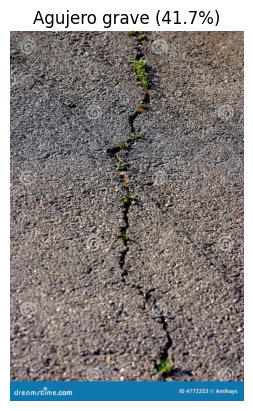

In [ ]:
predecir_imagen(r'C:\Users\Marcos.Gomez\OneDrive - Antolin\Desktop\TFG\ModeloIA\IMG\grieta.webp')